In [2]:
import jax
print("JAX path:", jax.__file__)

JAX path: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jax/__init__.py


In [3]:
## load module
import bstpp
import numpy as np
import numpyro.distributions as dist
import pandas as pd
import geopandas as gpd
from datetime import timedelta
import matplotlib.pyplot as plt
np.random.seed(16)

In [4]:
from bstpp.main import LGCP_Model, Hawkes_Model, load_Chicago_Shootings, load_Boko_Haram

In [5]:
## set working directory
import os
os.chdir("/Users/yuxin/Dropbox/DDDI/Illegal-Dumping")

In [6]:
## load data
litter_24 = gpd.read_file('data/311/2024/public_cases_fc.shp')

## filter data
illegal_dumping_24 = litter_24[litter_24['service_na'] == "Illegal Dumping"]


In [7]:
## prepare boundry of philly like "boundry"

# load shapefile of PA in 2024 from ACS
PA = gpd.read_file('data/tl_2024_42_bg/tl_2024_42_bg.shp')

# restrict to philly
philly = PA[PA['COUNTYFP'] == "101"]

# add a small buffer to the boundaries
philly_buffered = philly.buffer(0.01)  # Add 0.01 degrees buffer

/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_37298/4138501801.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  philly_buffered = philly.buffer(0.01)  # Add 0.01 degrees buffer


In [8]:
# filter points in philly
illegal_dumping_24 = illegal_dumping_24.sjoin(philly, predicate='within')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:2391: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [12]:
## prepare locs and t as "events_2022" from the sample data

# jitter the time
illegal_dumping_24['jittered_time'] = illegal_dumping_24['requested_'] + \
    pd.to_timedelta(np.random.uniform(0, 86400, len(illegal_dumping_24)), unit='s')

# get coordinates from the geometry
coords = pd.DataFrame({
    'x': illegal_dumping_24.geometry.centroid.x,
    'y': illegal_dumping_24.geometry.centroid.y
})

# calculate time difference in days from the minimum date
min_time = illegal_dumping_24['jittered_time'].min()
time_diff = (illegal_dumping_24['jittered_time'] - min_time).dt.total_seconds() / (24 * 60 * 60)

locs_s = pd.DataFrame({'X': coords['x'], 'Y': coords['y'], 'T': time_diff})

# Reset index and ensure proper column names
locs_s = locs_s.reset_index(drop=True)

# Make sure columns are properly named and data types are correct
locs_s = pd.DataFrame({'X': coords['x'], 'Y': coords['y'], 'T': time_diff})
locs_s = locs_s.astype({'X': float, 'Y': float, 'T': float})

/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_37298/1739360019.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'x': illegal_dumping_24.geometry.centroid.x,
/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_37298/1739360019.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'y': illegal_dumping_24.geometry.centroid.y


In [31]:
## sample locs_s data
# First, let's create time bins to ensure even distribution
n_samples = 5000
n_bins = 20  # You can adjust this number

# Create time bins and assign them to the data
locs_s['time_bin'] = pd.qcut(locs_s['T'], q=n_bins, labels=False)

# Stratified sampling from each bin
samples_per_bin = n_samples // n_bins
sampled_locs = pd.DataFrame()
for bin_id in range(n_bins):
    bin_data = locs_s[locs_s['time_bin'] == bin_id]
    sampled_bin = bin_data.sample(n=min(samples_per_bin, len(bin_data)))
    sampled_locs = pd.concat([sampled_locs, sampled_bin])

# If we need exactly 2000 points (in case of rounding)
if len(sampled_locs) < n_samples:
    remaining = n_samples - len(sampled_locs)
    additional = locs_s[~locs_s.index.isin(sampled_locs.index)].sample(n=remaining)
    sampled_locs = pd.concat([sampled_locs, additional])

# Drop the time_bin column as we don't need it anymore
sampled_locs = sampled_locs.drop('time_bin', axis=1)

# Sort by time
sampled_locs = sampled_locs.sort_values('T')

# Reset index and drop it
sampled_locs = sampled_locs.reset_index(drop=True)

In [32]:
sampled_locs.head()

,X,Y,T
0,-75.143845,39.984684,0.000000
1,-75.064855,40.013461,0.075525
2,-75.202023,40.007483,0.356028
3,-75.050555,40.023207,0.410281
4,-75.177624,39.980250,0.418714


In [33]:
## Cox-Hawkes model
model = Hawkes_Model(sampled_locs,#spatiotemporal points
                     philly,#philly boundaries
                     365,#Time frame (1 yr)
                     True,#use Cox as background
#                     spatial_cov=data['covariates'],#spatial covariate matrix
#                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(1,10), alpha = dist.Beta(20,60),#set priors
                     beta=dist.HalfNormal(2.0),sigmax_2=dist.HalfNormal(0.25)
                    )

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/bstpp/main.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))


In [34]:
model.run_svi(lr=0.02,num_steps=15000)

 32%|███▏      | 4867/15000 [16:44<34:51,  4.84it/s, init loss: -27757.7930, avg. loss [3751-4500]: -90733.6016]


KeyboardInterrupt: 

In [20]:
model.save_rslts('output/sample_2024_2000/cox_hawkes_output.pkl')

In [21]:
model.load_rslts('output/sample_2024_2000/cox_hawkes_output.pkl')

In [22]:
model.log_expected_likelihood(sampled_locs)


12436.7470703125

In [23]:
model.expected_AIC()

-19969.517578125

0.07966090738773346

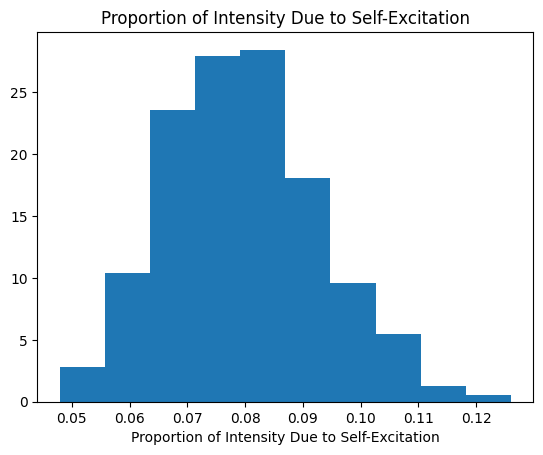

In [24]:
model.plot_prop_excitation()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
alpha,9.981757e-02,0.016213,1.0,7.245792e-02,1.328666e-01
beta,1.003518e+01,0.728938,1.0,8.671812e+00,1.144546e+01
sigmax_2,3.538783e-07,0.000008,1.0,4.025344e-17,1.898818e-07


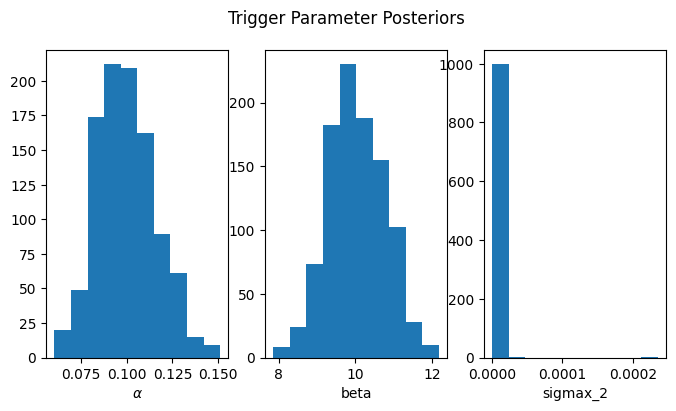

In [25]:
model.plot_trigger_posterior(trace=False)


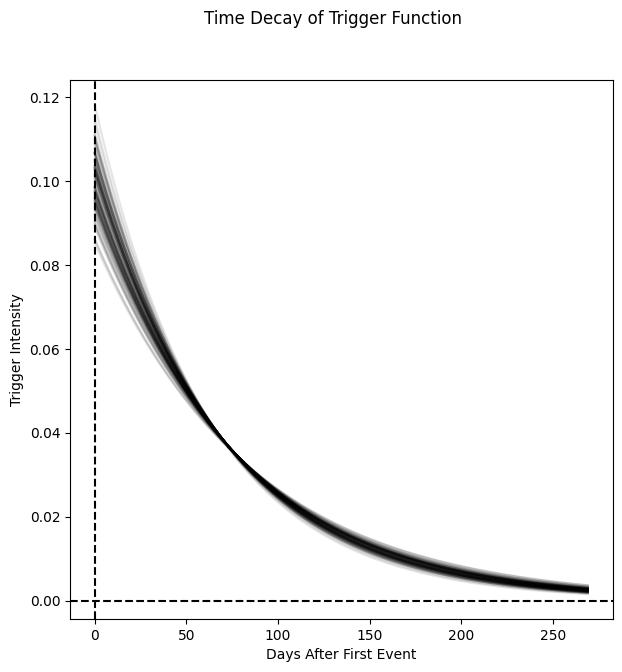

In [26]:
model.plot_trigger_time_decay()


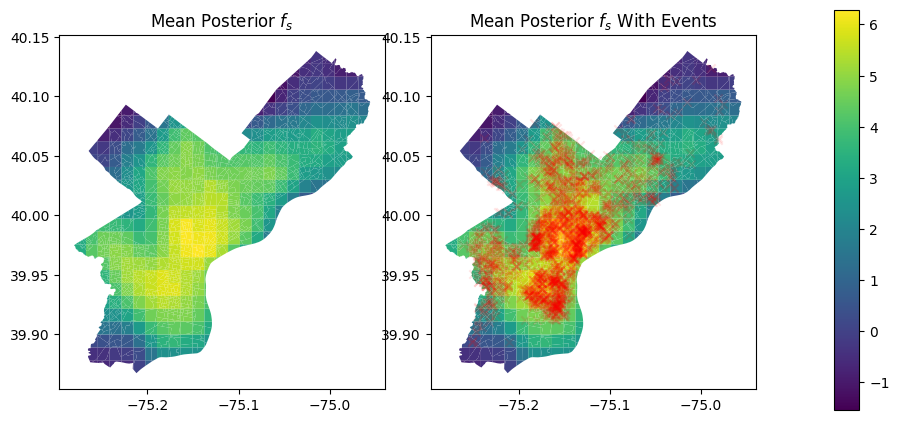

In [28]:
model.plot_spatial(include_cov=False)


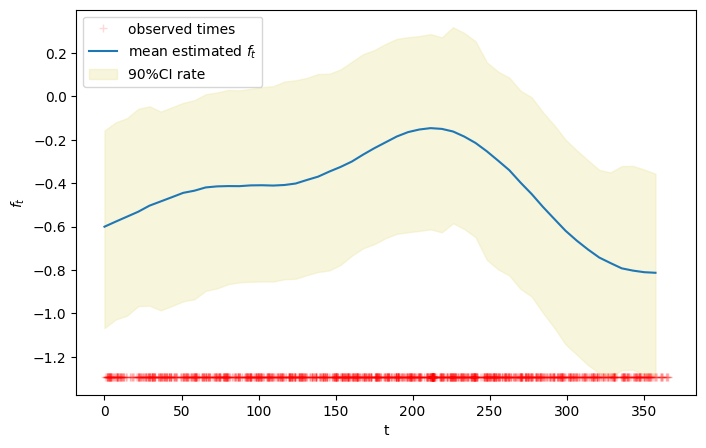

In [29]:
model.plot_temporal()